## Comparing all filtering methods

In [1]:
import Simulator
import Observation
import Statistics

import KalmanFilter
import ETKalmanFilter
import SLETKalmanFilter
import IEWParticleFilter

import Comparer

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [3]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


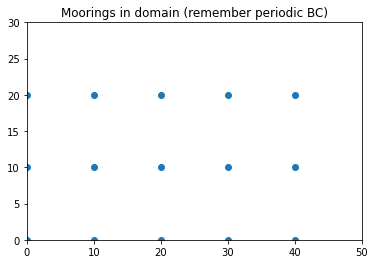

In [4]:
observation.plot_positions()

In [5]:
stop_simulation_early = False

if stop_simulation_early:
    observation.N_obs = 5


## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [6]:
prior_args = Statistics.prior_args_from_file(timestamp)

## New truth if changes intended

In [7]:
new_truth = True

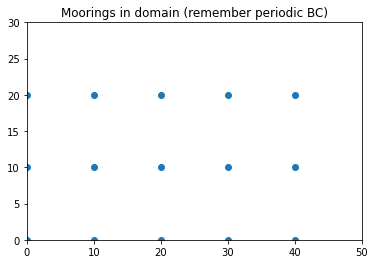

0
1
2
3
4
5
6
7
8
9


In [8]:
if new_truth:
    observation.clear_observations()
    observation.set_regular_positions(10)
    observation.plot_positions()

    # Temp changes only!
    simulator = Simulator.Simulator(grid, 
                                D=0.125, 
                                v=[1.5,0.5],
                                zeta=-0.0001,
                                dt=0.01,
                                noise_matern_phi=7.0,
                                noise_stddev=0.125)

    statistics_truth = Statistics.Statistics(simulator, 1)
    statistics_truth.set_prior(prior_args)

    for t in range(10):
        print(t)
        statistics_truth.propagate(25)
        #statistics_truth.plot()
        observation.observe(statistics_truth.mean)

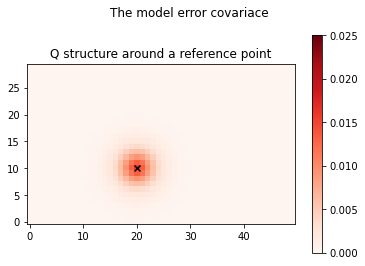

In [9]:
from matplotlib import pyplot as plt
import numpy as np
plt.suptitle("The model error covariace")
plt.title("Q structure around a reference point")
plt.imshow(np.reshape(simulator.cov_matrix()[520,:],(grid.ny,grid.nx)), origin="lower", vmin=0.0, vmax=0.025,cmap="Reds")
plt.colorbar()
plt.scatter(20,10, marker="x", c="black")

## Kalman filtering

Updating/conditioning the distributions at every observation time

Please remember to set priors!


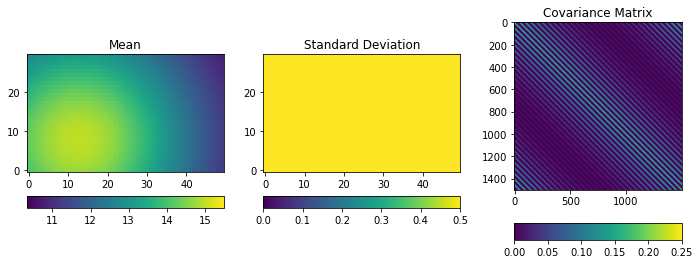

In [10]:
statistics_kf = Statistics.Statistics(simulator, safe_history=True)
statistics_kf.set_prior(prior_args)

statistics_kf.plot()

In [11]:
kalmanFilter = KalmanFilter.Kalman(statistics_kf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_kf.propagate(25)
    kalmanFilter.filter(statistics_kf.mean, statistics_kf.cov, observation.obses[t])
    #statistics_kf.plot()

0
1
2
3
4
5
6
7
8
9


# Ensemble-based filtering 

In [12]:
N_e = 50

## ETKF filtering

Updating/conditioning the distributions at every observation time

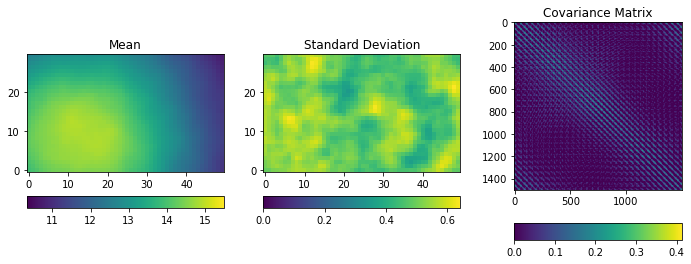

In [13]:
statistics_etkf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_etkf.set_prior(prior_args)

statistics_etkf.plot()

In [14]:
etkFilter = ETKalmanFilter.ETKalman(statistics_etkf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_etkf.propagate(25)
    etkFilter.filter(statistics_etkf.ensemble.ensemble, observation.obses[t])
    #statistics_etkf.plot()

0
1
2
3
4
5
6
7
8
9


## LETKF filtering

Updating/conditioning the distributions at every observation time

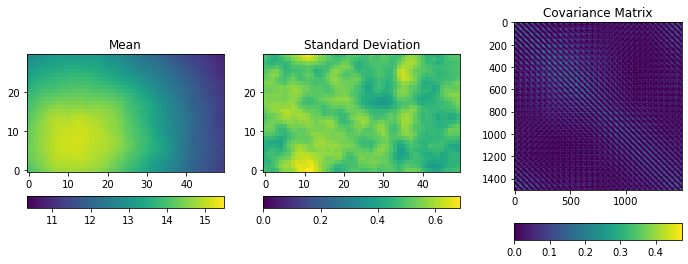

In [15]:
statistics_letkf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_letkf.set_prior(prior_args)

statistics_letkf.plot()

In [16]:
from importlib import reload
reload(SLETKalmanFilter)

<module 'SLETKalmanFilter' from '/home/florianb/advectionDiffusion/SLETKalmanFilter.py'>

In [17]:
# We choose the scale_r as about 2/3 of the correlation length in grid cells 
scale_r = 8

In [18]:
sletkFilter = SLETKalmanFilter.SLETKalman(statistics_letkf, observation, scale_r)

In [19]:
sletkFilter.groups

[[0, 2, 6, 8, 14], [1, 4, 5, 7, 13], [11, 3, 9], [10, 12]]

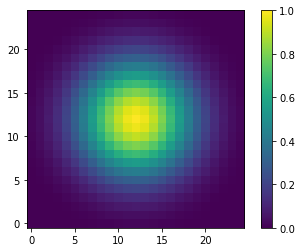

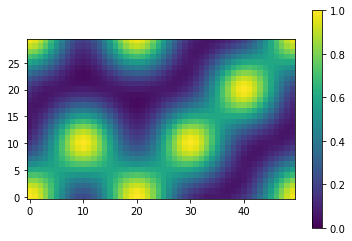

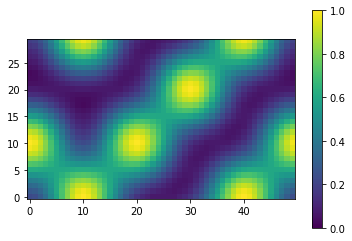

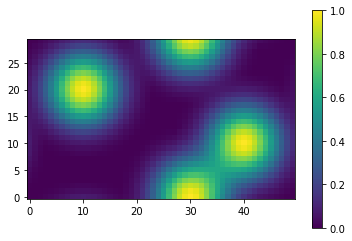

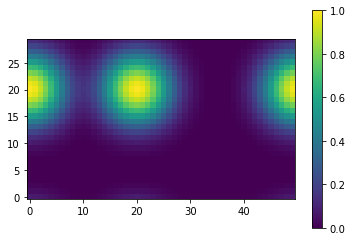

In [20]:
from matplotlib import pyplot as plt
plt.imshow(sletkFilter.W_loc, origin="lower", vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()
for g in range(len(sletkFilter.groups)):
    plt.imshow(sletkFilter.W_analyses[g], origin="lower", vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.show()

In [21]:
for t in range(observation.N_obs):
    print(t)
    statistics_letkf.propagate(25)
    sletkFilter.filter(statistics_letkf.ensemble.ensemble, observation.obses[t])
    #statistics_letkf.plot()

0
1
2
3
4
5
6
7
8
9


## IEWPF filtering

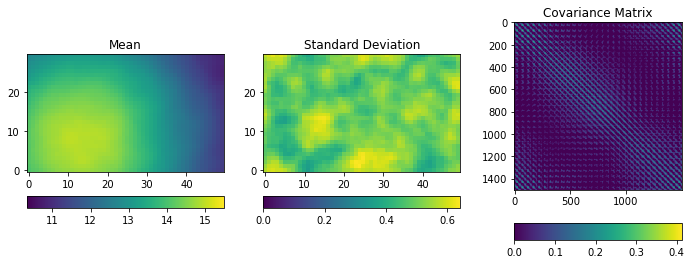

In [22]:
statistics_iewpf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_iewpf.set_prior(prior_args)

statistics_iewpf.plot()

In [23]:
from importlib import reload
reload(IEWParticleFilter)

<module 'IEWParticleFilter' from '/home/florianb/advectionDiffusion/IEWParticleFilter.py'>

In [24]:
iewpFilter = IEWParticleFilter.IEWParticle(statistics_iewpf, observation, 0.55)

for t in range(observation.N_obs):
    print(t)
    statistics_iewpf.propagate(25, model_error=False)
    iewpFilter.filter(statistics_iewpf.ensemble.ensemble, observation.obses[t])
    #statistics_iewpf.plot()

0
Model error in historical forecast added
1
Model error in historical forecast added
2
Model error in historical forecast added
3
Model error in historical forecast added
4
Model error in historical forecast added
5
Model error in historical forecast added
6
Model error in historical forecast added
7
Model error in historical forecast added
8
Model error in historical forecast added
9
Model error in historical forecast added


## Monte Carlo Experiment

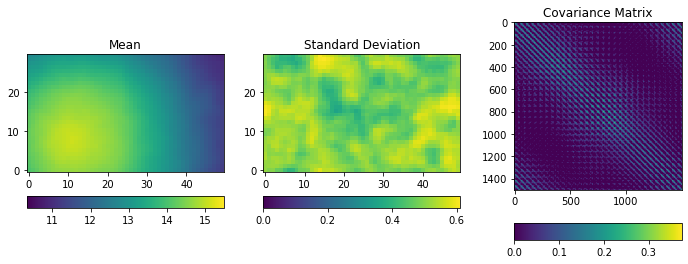

In [25]:
statistics_mc = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_mc.set_prior(prior_args)

statistics_mc.plot()

In [26]:
for t in range(observation.N_obs):
    print(t)
    statistics_mc.propagate(25, model_error=False)
    #statistics_mc.plot()

0
Model error in historical forecast added
1
Model error in historical forecast added
2
Model error in historical forecast added
3
Model error in historical forecast added
4
Model error in historical forecast added
5
Model error in historical forecast added
6
Model error in historical forecast added
7
Model error in historical forecast added
8
Model error in historical forecast added
9
Model error in historical forecast added


## Comparison

In [27]:
result_timestamp = None

In [28]:
from importlib import reload  
reload(Comparer)

<module 'Comparer' from '/home/florianb/advectionDiffusion/Comparer.py'>

In [29]:
comparer = Comparer.Comparer(statistics_kf, statistics_etkf, statistics_letkf, statistics_iewpf)

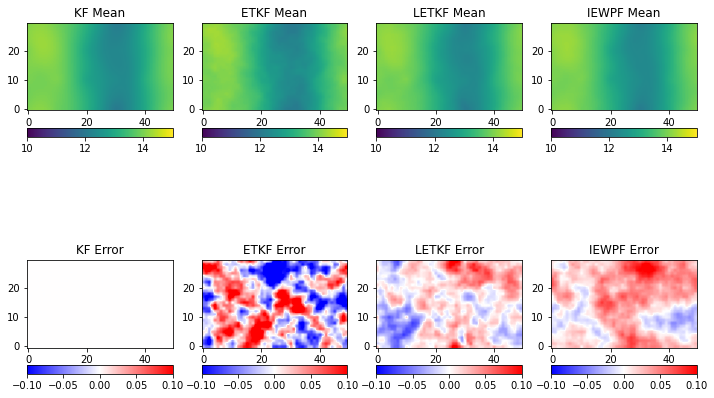

In [30]:
mean_err_etkf, mean_err_letkf, mean_err_iewpf = comparer.mean_plots()

In [31]:
save_rmse = False

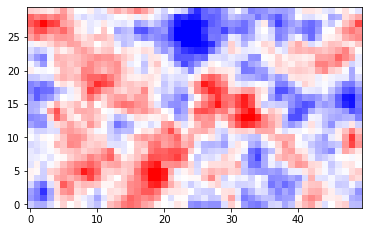

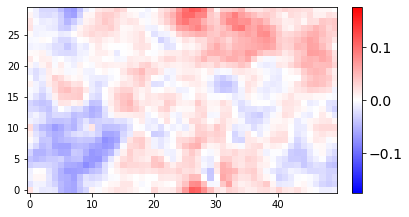

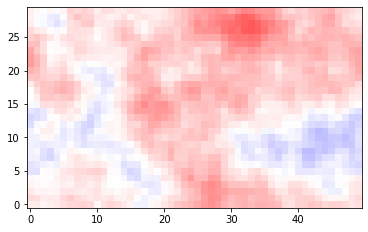

In [32]:
if save_rmse: 
    import numpy as np
    import datetime 
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    result_timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    filepath = "experiment_files/experiment_" + timestamp + "/"
    
    fig1, ax1 = plt.subplots(figsize=(6,4))
    im1 = ax1.imshow(mean_err_etkf, origin = "lower", vmin=-0.175, vmax=0.175, cmap="bwr")
    plt.savefig(filepath + "rmse_etkf_" + result_timestamp + ".png")
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(6,4))
    im2 = ax2.imshow(mean_err_letkf, origin = "lower", vmin=-0.175, vmax=0.175, cmap="bwr")
    ax_divider = make_axes_locatable(ax2)
    ax_cb = ax_divider.append_axes("right", size="3%", pad="5%")
    cbar = plt.colorbar(im2, cax=ax_cb)
    cbar.ax.tick_params(labelsize=14) 
    plt.savefig(filepath + "rmse_letkf_" + result_timestamp + ".png")
    plt.show()

    fig3, ax3 = plt.subplots(figsize=(6,4))
    im3 = ax3.imshow(mean_err_iewpf, origin = "lower", vmin=-0.175, vmax=0.175, cmap="bwr")
    plt.savefig(filepath + "rmse_iewpf_" + result_timestamp + ".png")
    plt.show()

In [33]:
mean_rmse_kf, mean_rmse_etkf, mean_rmse_letkf, mean_rmse_iewpf = comparer.mean_rmse()

print("RMSE of KF = ", mean_rmse_kf)
print("RMSE of ETKF = ", mean_rmse_etkf)
print("RMSE of LETKF = ", mean_rmse_letkf)
print("RMSE of IEWPF = ", mean_rmse_iewpf)

RMSE of KF =  0.0
RMSE of ETKF =  2.5422553319892147
RMSE of LETKF =  1.172760811021395
RMSE of IEWPF =  1.4205175301283608


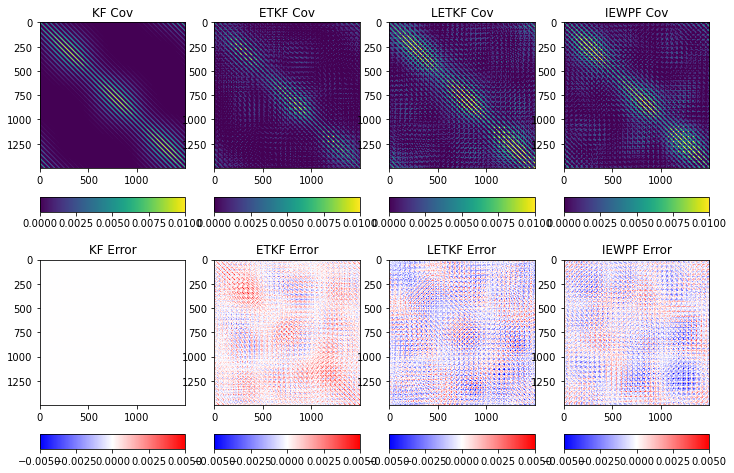

In [34]:
comparer.cov_plots()

In [35]:
cov_frob_kf, cov_frob_etkf, cov_frob_letkf, cov_frob_iewpf = comparer.cov_frobenius_dist()

print("Frobenius error in Cov matrix (KF) = ", cov_frob_kf)
print("Frobenius error in Cov matrix (ETKF) = ", cov_frob_etkf)
print("Frobenius error in Cov matrix (LETKF) = ", cov_frob_letkf)
print("Frobenius error in Cov matrix (IEWPF) = ", cov_frob_iewpf)

Frobenius error in Cov matrix (KF) =  0.0
Frobenius error in Cov matrix (ETKF) =  3.221018846197147
Frobenius error in Cov matrix (LETKF) =  4.186563047803776
Frobenius error in Cov matrix (IEWPF) =  3.7343022905174874


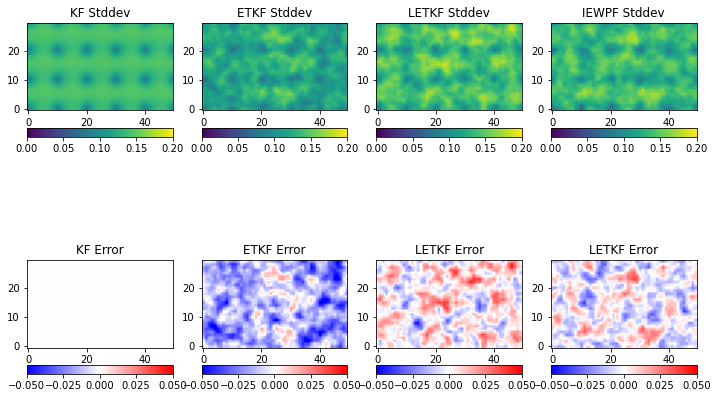

In [36]:
comparer.stddev_plots()

In [37]:
stddev_rmse_kf, stddev_rmse_etkf, stddev_rmse_letkf, stddev_rmse_iewpf = comparer.stddev_rmse()

print("RMSE of KF = ", stddev_rmse_kf)
print("RMSE of ETKF = ", stddev_rmse_etkf)
print("RMSE of LETKF = ", stddev_rmse_letkf)
print("RMSE of IEWPF = ", stddev_rmse_iewpf)

RMSE of KF =  0.0
RMSE of ETKF =  0.8134780128876198
RMSE of LETKF =  0.5095778401978499
RMSE of IEWPF =  0.4715644147429818


In [38]:
reload(Comparer)
comparer = Comparer.Comparer(statistics_kf, statistics_etkf, statistics_letkf, statistics_iewpf)

In [39]:
comparer.set_poi([0,0])
comparer.set_poi([25,15])
comparer.set_poi([1,0])

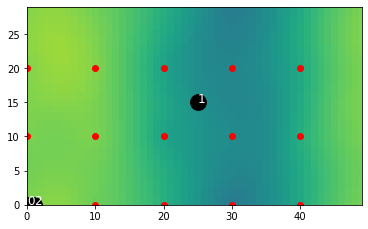

In [40]:
comparer.poi_plot(observation)

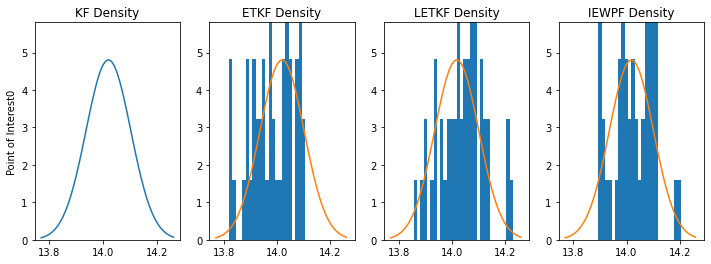

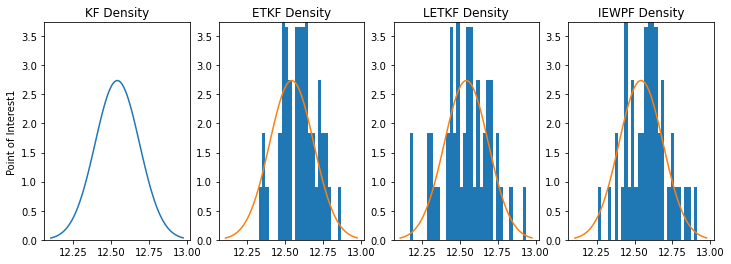

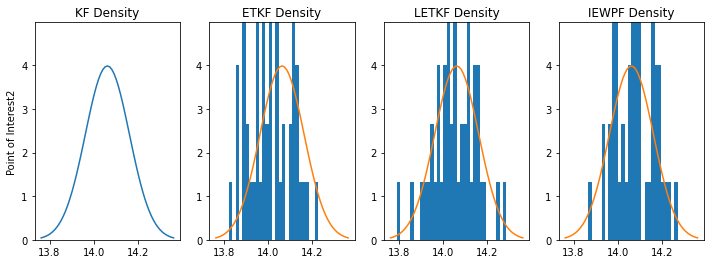

In [41]:
comparer.poi_hist(0)
comparer.poi_hist(1)
comparer.poi_hist(2)

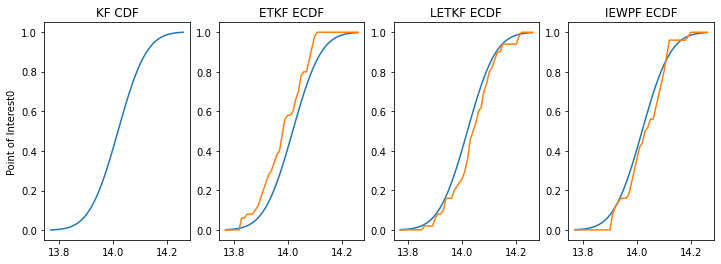

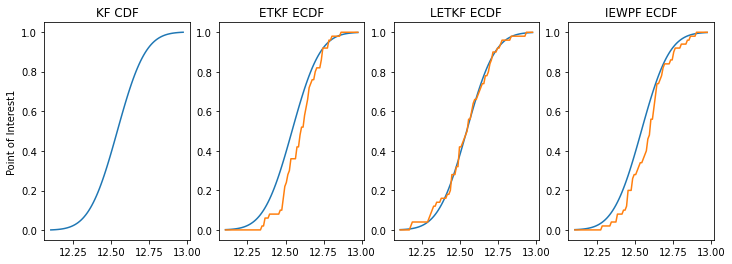

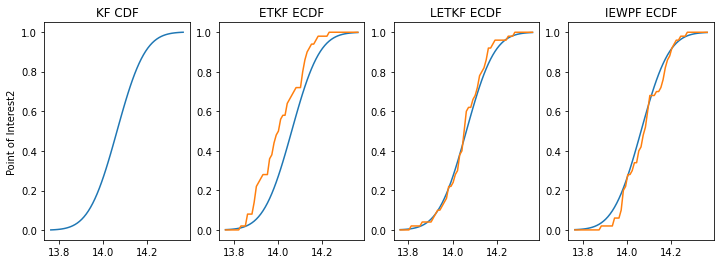

In [42]:
cdf0, ecdf_etkf0, ecdf_letkf0, ecdf_iewpf0 = comparer.poi_ecdf_plots(0)
cdf1, ecdf_etkf1, ecdf_letkf1, ecdf_iewpf1 = comparer.poi_ecdf_plots(1)
cdf2, ecdf_etkf2, ecdf_letkf2, ecdf_iewpf2 = comparer.poi_ecdf_plots(2)

In [57]:
save_cdf = False

In [58]:
if save_cdf: 
    import numpy as np
    import datetime 
    
    if result_timestamp is None:
        result_timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    filepath = "experiment_files/experiment_" + timestamp + "/"
    cdf_file = filepath + "cdf_" + result_timestamp
    
    x = np.arange(10,15,0.01)
    cdf_table = np.column_stack((x,cdf0(x),cdf1(x),cdf2(x)))
    np.savetxt(cdf_file, cdf_table)

    ecdf_file = filepath + "ecdf_" + result_timestamp

    y_ecdf = np.arange(0,1,1/N_e)+1/N_e
    ecdf_table = np.column_stack( (y_ecdf, ecdf_etkf0, ecdf_letkf0, ecdf_iewpf0) ) 
    ecdf_table = np.column_stack( (ecdf_table, ecdf_etkf1, ecdf_letkf1, ecdf_iewpf1))
    ecdf_table = np.column_stack( (ecdf_table, ecdf_etkf2, ecdf_letkf2, ecdf_iewpf2))
    ecdf_table = np.row_stack( (np.repeat(0,10), ecdf_table, np.hstack((np.array([1]),np.repeat(15,9)))) ) 
    np.savetxt(ecdf_file, ecdf_table)

In [45]:
ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(0)

print("Difference at pos0 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos0 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos0 (IEWPF) = ",ecdf_err_iewpf)

ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(1)

print("Difference at pos1 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos1 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos1 (IEWPF) = ",ecdf_err_iewpf)

ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(2)

print("Difference at pos2 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos2 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos2 (IEWPF) = ",ecdf_err_iewpf)

/home/florianb/advectionDiffusion/Comparer.py:365: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ecdf_err_etkf = scipy.integrate.quad(diff_etkf, xmin, xmax, limit=100)[0]
/home/florianb/advectionDiffusion/Comparer.py:366: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and call

Difference at pos0 (ETKF) =  0.036547716445124855
Difference at pos0 (LETKF) =  0.02115445644584175
Difference at pos0 (IEWPF) =  0.017293267009276664
Difference at pos1 (ETKF) =  0.0557781993437853
Difference at pos1 (LETKF) =  0.01380578943772797
Difference at pos1 (IEWPF) =  0.045971838825427394
Difference at pos2 (ETKF) =  0.05599240638354582
Difference at pos2 (LETKF) =  0.012619910291595307
Difference at pos2 (IEWPF) =  0.0176060296702965


## Correlation Study

Analytic correlation of two points $s_0$ at time $t_0$ and $s_1$ at time $t_1 = t_0 + \Delta t$ where sites are chosen in advection direction

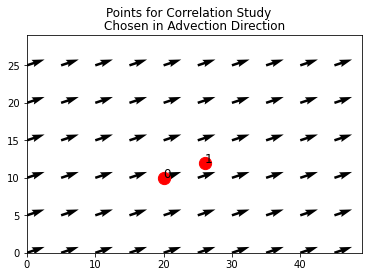

In [46]:
points = [[20,10],[26,12]]

simulator.plot_correlation_points(points)


Analytical calculations as suggested by Jo

In [47]:
statistics_kf.evaluate_correlation(points)

0.24827995811963646

Empirical estimations

$Corr = \frac{1}{N_e-1} \frac{1}{\sigma_{t=9}(x_0)\sigma_{t=10}(x_2)} \sum (c^e_{t=9}(x_0) - \overline{c_{t=9}(x_0)})(c^e_{t=10}(x_1) - \overline{c_{t=10}(x_1)}) $

In [48]:
statistics_etkf.evaluate_correlation(points)

0.18937379443824487

In [49]:
statistics_letkf.evaluate_correlation(points)

0.5324414292014424

In [50]:
statistics_iewpf.evaluate_correlation(points)

0.3809122570374381

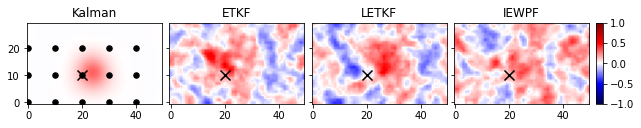

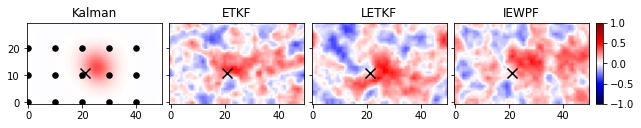

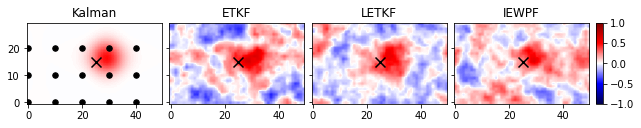

In [51]:
corr_ref_pois = [[20,10],[21,11],[25,15]]
comparer.set_corr_ref_pois(corr_ref_pois)

for p in range(len(corr_ref_pois)):
    corr_grid_kf, corr_grid_etkf, corr_grid_letkf, corr_grid_iewpf = comparer.corr_p2p_plot(p, observation)

In [52]:
print("Maximal correlation KF", np.max(corr_grid_kf))
print("Maximal correlation ETKF", np.max(corr_grid_etkf))
print("Maximal correlation LETKF", np.max(corr_grid_letkf))
print("Maximal correlation IEWPF", np.max(corr_grid_iewpf))

Maximal correlation KF 0.485175534995277
Maximal correlation ETKF 0.6666680792705376
Maximal correlation LETKF 0.5717278600183805
Maximal correlation IEWPF 0.6072173386818284


In [53]:
import numpy as np
print("ETKF difference ",  np.linalg.norm(corr_grid_kf - corr_grid_etkf))
print("LETKF difference ", np.linalg.norm(corr_grid_kf - corr_grid_letkf))
print("IEWPF difference ", np.linalg.norm(corr_grid_kf - corr_grid_iewpf))

ETKF difference  5.846490946660484
LETKF difference  4.874851743945172
IEWPF difference  5.087767045985594


In [54]:
print("ETKF difference close to max ",  np.linalg.norm((corr_grid_kf - corr_grid_etkf)*(corr_grid_kf>0.1)))
print("LETKF difference close to max ", np.linalg.norm((corr_grid_kf - corr_grid_letkf)*(corr_grid_kf>0.1)))
print("IEWPF difference close to max ", np.linalg.norm((corr_grid_kf - corr_grid_iewpf)*(corr_grid_kf>0.1)))

ETKF difference close to max  1.9747569217575665
LETKF difference close to max  1.4041462251464647
IEWPF difference close to max  1.033850036337024


In [55]:
print("ETKF difference far away max ",  np.linalg.norm((corr_grid_kf - corr_grid_etkf)*(corr_grid_kf<0.1)))
print("LETKF difference far away max ", np.linalg.norm((corr_grid_kf - corr_grid_letkf)*(corr_grid_kf<0.1)))
print("IEWPF difference far away max ", np.linalg.norm((corr_grid_kf - corr_grid_iewpf)*(corr_grid_kf<0.1)))

ETKF difference far away max  5.502889376441578
LETKF difference far away max  4.668249447475168
IEWPF difference far away max  4.981618975451948


#### Just some comparison of model error and ensemble covariance

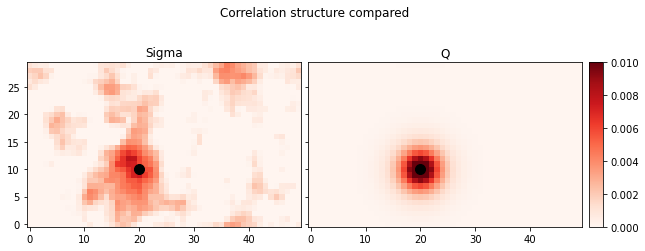

In [56]:
indicator_field = np.zeros((grid.ny,grid.nx))
indicator_field[points[0][1],points[0][0]] = 1.0
idx = np.where(indicator_field.flatten() != 0)

fig = plt.figure(figsize=(8,4))
fig.suptitle("Correlation structure compared")

from mpl_toolkits.axes_grid1 import AxesGrid

axs = AxesGrid(fig, (0.0,0.0,1.0,1.0), nrows_ncols=(1,2), axes_pad=0.1,
    cbar_mode="single", cbar_location="right", cbar_pad=0.1)

fig0 = axs[0].imshow(np.reshape(statistics_iewpf.cov[idx,:],(grid.ny,grid.nx)), origin="lower", vmin=0.0, vmax=0.01,cmap="Reds")
axs[0].set_title("Sigma")
axs[0].scatter(20, 10, s=100, c="black")

fig1 = axs[1].imshow(np.reshape(statistics_iewpf.simulator.Q[idx,:],(grid.ny,grid.nx)), origin="lower", vmin=0.0, vmax=0.01,cmap="Reds")
axs[1].set_title("Q")
axs[1].scatter(20, 10, s=100, c="black")

cbar = axs[0].cax.colorbar(fig0)